In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("dat.csv")
df = df.drop(['employees_created'], axis=1)
df = df.drop(['employee_id'], axis=1)
df["age"] = df["age"].fillna(df["age"].mean())
from sklearn.preprocessing import LabelEncoder
df_a = df.copy()

# Create a label encoder object
le = LabelEncoder()
le_count = 0

le.fit(df_a['influx_route_big'])
# Transform both training and testing data
df_a['influx_route_big'] = le.transform(df_a['influx_route_big'])
df_b = pd.get_dummies(df_a['influx_route_big'], drop_first = True)

# one-hot encoding of categorical variables
df_b.columns = ['influx_0','influx_1','influx_2','influx_3','influx_4','influx_5','influx_6','influx_7']
df = pd.concat([df, df_b], axis=1)

df = df.drop(['influx_route_big'], axis=1)
pd.set_option('display.max_columns', 100)
df.head()

,age,gender,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,influx_0,influx_1,influx_2,influx_3,influx_4,influx_5,influx_6,influx_7
0,26.0,0,5,5,5,11,15,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
1,25.0,1,8,8,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,24.0,1,3,3,2,0,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,25.0,1,3,3,4,7,56,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
4,26.0,1,4,4,3,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0


In [2]:
df_train = df.copy()

#変数を配列へ変換
from sklearn.cross_validation import train_test_split

X = df_train.drop("objective_variable" , axis=1).values
y = df_train["objective_variable"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#2. 学習
import numpy as np
import scipy as sp
import xgboost as xgb
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
predict = xgb_model.predict(X_test)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


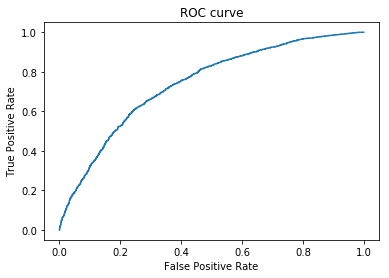

In [4]:
from sklearn import metrics as mtr
%matplotlib inline
from matplotlib import pyplot as plt

prob = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = mtr.roc_curve(y_test, prob,pos_label =1)

plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [5]:
# 3.まとめ（精度計算）

class_predict = xgb_model.predict(X_test)
print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,class_predict))
print('テストデータに対する roc-auc： %.4f' %mtr.roc_auc_score(y_test, prob))
print('テストデータに対する log-loss： %.4f' %mtr.log_loss(y_test, prob))

テストデータに対する正解率： 0.7017
テストデータに対する roc-auc： 0.7400
テストデータに対する log-loss： 0.5808


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [6]:
#RandomizedSearchCVを使用した学習
param_distributions={'max_depth': sp.stats.randint(1,11),
                     'subsample': sp.stats.uniform(0.5,0.5),
                     'colsample_bytree': sp.stats.uniform(0.5,0.5)
}

xgb_model = xgb.XGBClassifier()
rs = RandomizedSearchCV(xgb_model,
                        param_distributions,
                        cv=10,
                        n_iter=20,
                        scoring="log_loss",
                        n_jobs=1,
                        verbose=2)
rs.fit(X_train, y_train)
predict = rs.predict(X_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.2s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.1s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.3s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.3s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.4s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.0s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.0s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.0s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.1s
[CV] colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6963910081653123, max_depth=4, subsample=0.9214126357902133 -   1.0s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   1.5s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   1.2s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   1.1s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   1.2s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   0.7s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   0.7s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   0.6s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   0.6s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   0.6s
[CV] colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6415711622030837, max_depth=3, subsample=0.8788521241886738 -   0.7s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.8s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.7s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   2.0s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   2.0s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.7s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   2.0s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.9s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.9s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.7s
[CV] colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.76113845249105, max_depth=7, subsample=0.9043407806046062 -   1.8s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.3s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.3s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.3s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.3s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.4s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.4s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.4s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.4s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.4s
[CV] colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7164397319171715, max_depth=1, subsample=0.6043967733226958 -   0.3s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.3s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.4s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.4s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.4s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.4s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.2s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.2s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.3s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.3s
[CV] colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6715189696454972, max_depth=10, subsample=0.9404954295088848 -   2.2s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.3s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.3s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.3s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.4s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.6s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.4s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.3s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.4s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.4s
[CV] colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9361125488244764, max_depth=4, subsample=0.5760782098562076 -   1.4s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.6s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.3s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.3s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.3s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.3s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.3s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.3s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.4s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.4s
[CV] colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7401363723727339, max_depth=10, subsample=0.9890103298031958 -   2.4s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.4s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.4s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8507611622308282, max_depth=1, subsample=0.9216854936098067 -   0.3s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.1s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.0s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.0s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.2s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.0s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.0s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.1s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.1s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   1.9s
[CV] colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.9401981655720852, max_depth=6, subsample=0.6927881465436292 -   2.0s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   2.0s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.9s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.8s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.8s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.8s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   2.0s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.9s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.9s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.8s
[CV] colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.730050070494711, max_depth=7, subsample=0.7566950879686559 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.9s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.9s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.8s
[CV] colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.807355757939987, max_depth=6, subsample=0.6700621209287116 -   1.7s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   1.0s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.7934350159365575, max_depth=3, subsample=0.7353933691138314 -   0.8s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.1s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.1s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.4s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.2s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.2s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.4s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.3s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.4s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.4s
[CV] colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8081308751873519, max_depth=5, subsample=0.9759576608101466 -   1.4s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   3.8s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.5s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.6s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.1s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.2s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.0s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.2s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.2s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   4.0s
[CV] colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8521643306224039, max_depth=10, subsample=0.5687985342437354 -   3.7s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.7s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.9s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.7s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.6s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.6s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.6s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.7s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.7s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.7s
[CV] colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6964494930454144, max_depth=3, subsample=0.9588871607811174 -   0.7s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.8s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.8s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.9s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.9s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.9s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.7s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.7s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.8s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.9s
[CV] colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6071535446201486, max_depth=8, subsample=0.8150126705927689 -   1.8s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.3s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.3s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.4s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.4s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.4s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.3s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.4s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.3s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.3s
[CV] colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8445332572317009, max_depth=1, subsample=0.8336976837716061 -   0.3s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.5s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.5s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.4s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.4s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.5s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.3s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.3s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.4s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.4s
[CV] colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.8641077866023901, max_depth=4, subsample=0.5521527020763464 -   1.3s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.1s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.0s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.0s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.0s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.1s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.6s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   3.0s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.6s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.5s
[CV] colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6815138412450801, max_depth=9, subsample=0.952098820450881 -   2.3s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.2s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.3s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.4s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.2s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.2s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.0s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.3s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.0s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.3s
[CV] colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.6min finished


[CV]  colsample_bytree=0.6524278453743928, max_depth=9, subsample=0.8266230043518813 -   2.5s


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


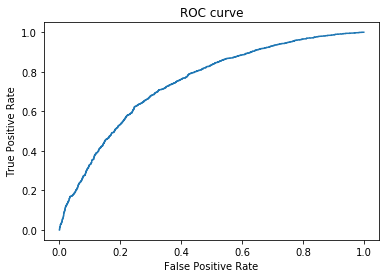

In [7]:
from sklearn import metrics as mtr
%matplotlib inline
from matplotlib import pyplot as plt

prob = rs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = mtr.roc_curve(y_test, prob,pos_label =1)

plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [8]:
# 3.まとめ（精度計算）

class_predict = rs.predict(X_test)
print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,class_predict))
print('テストデータに対する roc-auc： %.4f' %mtr.roc_auc_score(y_test, prob))
print('テストデータに対する log-loss： %.4f' %mtr.log_loss(y_test, prob))

テストデータに対する正解率： 0.7036
テストデータに対する roc-auc： 0.7459
テストデータに対する log-loss： 0.5759


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9361125488244764, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5760782098562076)

### 参考文献
http://tekenuko.hatenablog.com/entry/2016/09/22/220814

In [17]:
# ハイパーパラメータ探索
from sklearn import model_selection

clf = xgb.XGBRegressor()
clf_cv = model_selection.GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_cv.fit(X_train,y_train)
print(clf_cv.best_params_, clf_cv.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   27.6s finished


{'max_depth': 4, 'n_estimators': 100} 0.17112341380293403


In [21]:
# 改めて最適パラメータで学習
clf = xgb.XGBRegressor(**clf_cv.best_params_)
model = clf.fit(X_train, y_train)

In [28]:
class_predict = model.predict(X_test)

In [30]:
print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,class_predict))

ValueError: Can't handle mix of binary and continuous

In [29]:
class_predict

array([0.75713146, 0.6991048 , 0.8430326 , ..., 0.70760226, 0.32800835,
       0.71567893], dtype=float32)